*Batch normalization*, a popular and effective
technique that consistently accelerates the convergence of deep networks.  

##Training Deep Networks
Batch normalization is applied to individual layers (optionally, to all of them) and works as follows:
1. Normalize the inputs (of batch normalization) by subtracting
their mean and dividing by their standard deviation, where both are estimated based on the statistics of the current minibatch.
2. Apply a scale coefficient and a scale offset.

**Note**: When applying batch normalization, the choice of batch size may be even more significant than without
batch normalization.  

Batch normalization(BN):  
an input $\mathbf{x} \in \mathcal{B}$, $\mathcal{B}$ is the minibatch, batch normalization transforms $\mathbf{x}$ according to the following expression:
$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta},$$
where $\hat{\boldsymbol{\mu}}_\mathcal{B}$ is the  sample mean
and $\hat{\boldsymbol{\sigma}}_\mathcal{B}$ is the sample standard deviation of the minibatch $\mathcal{B}$; *scale parameter* $\boldsymbol{\gamma}$ and *shift parameter* $\boldsymbol{\beta}$ are parameters that need to be learned jointly with the other model parameters. We calculate $\hat{\boldsymbol{\mu}}_\mathcal{B}$ and ${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$ as follows:
$$\begin{aligned} \hat{\boldsymbol{\mu}}_\mathcal{B} &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.\end{aligned}$$

**Note**:
1. Batch normalization seems to
allow for more aggressive learning rates.
2. Use $\epsilon > 0$ to ensure that we never attempt
division by zero.
3. *Training mode* (normalizing by minibatch statistics) and *prediction mode* (normalizing by
dataset statistics).

##Batch Normalization Layers
One key differences between batch
normalization and other layers is that because batch normalization operates on a full minibatch
at a time

###Fully-Connected Layers
Apply batch normalization after the affine transformation and before the nonlinear activation function (later
applications may insert batch normalization right after activation functions).  

Denoting the input to the fully-connected layer by $\mathbf{x}$,
the affine transformation
by $\mathbf{W}\mathbf{x} + \mathbf{b}$ (with the weight parameter $\mathbf{W}$ and the bias parameter $\mathbf{b}$),
and the activation function by $\phi$,
we can express the computation of a batch-normalization-enabled,
fully-connected layer output $\mathbf{h}$ as follows:

$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

Note that mean and variance are computed on the same minibatch on which the transformation
is applied.

###Convolutional Layers
Apply batch normalization after the convolution and
before the nonlinear activation function.  

For each output channel, compute the mean and variance within the given channel and normalize the output.

##Implementation 

In [ ]:
!pip install d2l

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
  if not torch.is_grad_enabled():
    # prediction mode
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    # training mode
    assert len(X.shape) in (2, 4)
    if len(X.shape) == 2:
      # fully-connected layer
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      # 2D convolutional layer
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
    
    X_hat = (X - mean) / torch.sqrt(var + eps)
    # update the mean and variance using moving average
    moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
    moving_var = momentum * moving_var + (1.0 - momentum) * var
  # scale and shift
  Y = gamma * X_hat + beta 
  return Y, moving_mean.data, moving_var.data

In [5]:
class BatchNorm(nn.Module):
  def __init__(self, num_features, num_dims):
    # num_features: the number of outputs for a fully-connected layer 
    #               or the number of output channels for a convolutional layer.
    # num_dims: 2 for a fully-connected layer and 4 for a convolutional layer.
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    # initialize the scale and shift parameters
    self.gamma = nn.Parameter(torch.ones(shape))
    self.beta = nn.Parameter(torch.zeros(shape))
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)
  
  def forward(self, X):
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)

    Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta,
                                                      self.moving_mean, self.moving_var, 
                                                      eps=1e-5, momentum=0.9)
    return Y

Apply BN to the LeNet model.  
Note that batch normalization is applied **after the convolutional layers or fully-connected
layers** but **before the corresponding activation functions**.

 

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.268, train acc 0.900, test acc 0.868
32282.8 examples/sec on cuda:0


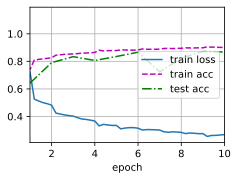

In [7]:
lr, num_epochs, batch_size = 1.0, 10, 256 # Note that the large learning rate
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [9]:
# concise implement with nn.BatchNorm2d()
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.268, train acc 0.902, test acc 0.859
45173.2 examples/sec on cuda:0


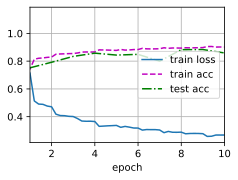

In [10]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

**Summary**:
1. During model training, batch normalization continuously adjusts the intermediate output
of the neural network by utilizing the mean and standard deviation of the minibatch, so that
the values of the intermediate output in each layer throughout the neural network are more
stable.
2. The batch normalization methods for fully-connected layers and convolutional layers are
slightly different.
3. Like a dropout layer, batch normalization layers have different computation results in training mode and prediction mode.
4. Batch normalization has many beneficial side effects, primarily that of **regularization**. On
the other hand, the original motivation of reducing internal covariate shift seems not to be
a valid explanation.